# Model Selection - Example

## Example Model
Measurement data are simulation results with the "true" model. The comprehensive model includes additional behaviour involving a third parameter. Hence, during model selection, models with $\theta_3=0$ should be preferred.

![](model_selection_network.jpeg)


# Model Space Specifications File

The model selection specification file can be written in the following compressed format.

| modelId | YAML                             | $\theta_1$ | $\theta_2$ | $\theta_3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1      | example_modelSelection.yaml | 0;-  | 0;-  | 0;-  |

Alternatively, models can be explicitly specified. The below table is equivalent to the above table.

| modelId | YAML                             | $\theta_1$ | $\theta_2$ | $\theta_3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1_0	| example_modelSelection.yaml	| 0	  | 0   |	0 | 
| M1_1	| example_modelSelection.yaml	| 0	  | 0	| - |
| M1_2	| example_modelSelection.yaml	| 0	  | - |	0 |
| M1_3	| example_modelSelection.yaml	| - |	0	| 0 |
| M1_4	| example_modelSelection.yaml	| 0	  | - |	- |
| M1_5	| example_modelSelection.yaml	| - |	0   |	- |
| M1_6	| example_modelSelection.yaml	| - |	- |	0 |
| M1_7	| example_modelSelection.yaml	| - |	- |	- |

Either of the above tables (as [.tsv](https://en.wikipedia.org/wiki/Tab-separated_values) files) are valid inputs. Any combinations of cells in the compressed or explicit format is also acceptable, including the following example.

| modelId | YAML                             | $\theta_1$ | $\theta_2$ | $\theta_3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1      | example_modelSelection.yaml | 0;-  | 0;-  | 0  |
| M2      | example_modelSelection.yaml | 0;-  | 0;-  | -  |

Due to the topology of the example model, setting $\theta_1$ to zero can result in a model with no dynamics. Hence, for this example, some parameters are set to non-zero fixed values. These parameters are not considered as estimated values in criterion (e.g. AIC) calculations.

Internally, estimated parameters (`-`) are represented by `float('nan')`.

In [1]:
model_spec_file = './model_selection/modelSelectionSpecification_example_modelSelection.tsv'
from pypesto.model_selection import unpack_file
f = unpack_file(model_spec_file)
f.seek(0)
print(f.read())

modelId	YAML	k1	k2	k3
M1_0_0	example_modelSelection.yaml	0	0	0
M1_1_0	example_modelSelection.yaml	0.2	0.1	nan
M1_2_0	example_modelSelection.yaml	0.2	nan	0
M1_3_0	example_modelSelection.yaml	nan	0.1	0
M1_4_0	example_modelSelection.yaml	0.2	nan	nan
M1_5_0	example_modelSelection.yaml	nan	0.1	nan
M1_6_0	example_modelSelection.yaml	nan	nan	0
M1_7_0	example_modelSelection.yaml	nan	nan	nan



# Forward Selection, Multiple Searches
Here, we show a typical workflow for model selection. First, a [PEtab](https://github.com/petab-dev/petab) problem is created. This is used to initialise a `ModelSelector`, along with a model specifications file.

In [2]:
petab_YAML = './model_selection/example_modelSelection.yaml'
import pypesto
import petab
petab_problem = petab.Problem.from_yaml(petab_YAML)
selector = pypesto.ModelSelector(petab_problem, model_spec_file)

Models can be selected with a model selection algorithm ([forward](https://en.wikipedia.org/wiki/Stepwise_regression)) and a comparison criterion ([AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)).

In [3]:
from pprint import pprint
selected_models, _, selection_history = selector.select('forward', 'AIC')

----------------------New Selection---------------------
Starting with model: M1_0_0

Old ID	New ID	Crit	Old	New	Diff	Result
M1_0_0	M1_1_0	AIC	42.975	-6.175	-49.151	Accepted


Parameters obtained from history and optimizer do not match: [0.10148095 0.12141852], [0.10147824 0.12142223]


M1_1_0	M1_2_0	AIC	-6.175	-4.275	1.901	Rejected
M1_1_0	M1_3_0	AIC	-6.175	-4.705	1.470	Rejected
M1_1_0	M1_4_0	AIC	-6.175	-4.275	1.901	Rejected
M1_1_0	M1_5_0	AIC	-6.175	-2.705	3.470	Rejected


Plotting routines are available, to visualise the best model at each iteration of the selection process.

[]

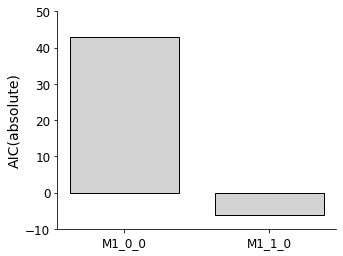

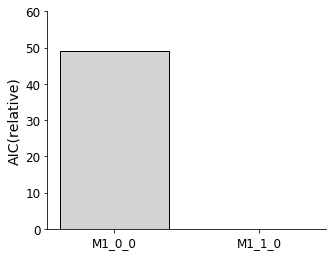

In [4]:
import pypesto.visualize.model_selection as visu
ax = visu.plot_selected_models(selected_models, criterion='AIC', relative=False)
ax = visu.plot_selected_models(selected_models, criterion='AIC')
ax.plot()

To search more of the model space, the algorithm can be repeated. As models with 1 or less estimated parameters have already been tested, subsequent `select` calls will begin with the next simplest model (in this case, models with exactly 2 estimated parameters), and move on to more complex models, while each iteration improves the criterion and additional valid models are available for testing.

In [5]:
selected_models, local_selection_history, selection_history = selector.select('forward', 'AIC')

----------------------New Selection---------------------
Starting with model: M1_6_0

Old ID	New ID	Crit	Old	New	Diff	Result
M1_6_0	M1_7_0	AIC	-4.148	-6.056	-1.909	Accepted


[]

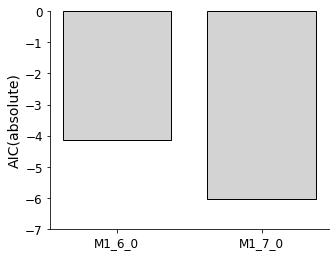

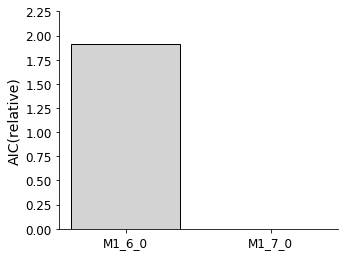

In [6]:
ax = visu.plot_selected_models(selected_models, criterion='AIC', relative=False)
ax = visu.plot_selected_models(selected_models, criterion='AIC')
ax.plot()

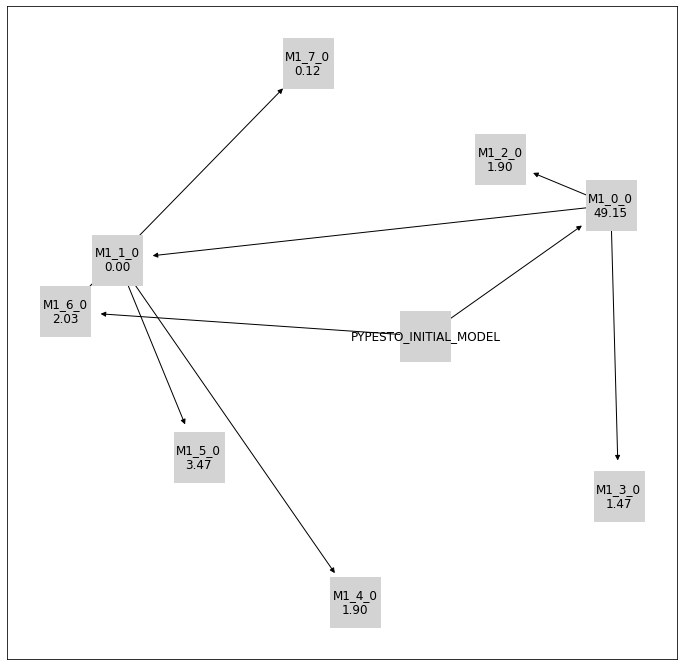

In [7]:
visu.plot_history_digraph(selection_history)

# Backward Selection, Custom Initial Model
Backward selection is specified by changing the algorithm from `'forward'` to `'backward'`in the `ModelSelector.select()` call.

A custom initial model is specified with the optional `initial_model` argument of `ModelSelector.select()`. If no initial model is specified, then a virtual model is used for the purpose of finding the next valid models. For example, in forward selection, the initial virtual model with all parameters set to zero is used to find the next models to be tested. For backward selection, the initial virtual model has all parameters set to be estimated.

In [8]:
selector2 = pypesto.ModelSelector(petab_problem, model_spec_file)
initial_model = dict(zip(selector2.header, ['myModel', 'not_implemented.xml', float(0.1), float('nan'), float('nan')]))
print(f'Model specifications file column headers: {selector2.header}')
print('Initial model:')
pprint(initial_model)

Model specifications file column headers: ['modelId', 'YAML', 'k1', 'k2', 'k3']
Initial model:
{'YAML': 'not_implemented.xml',
 'k1': 0.1,
 'k2': nan,
 'k3': nan,
 'modelId': 'myModel'}


In [9]:
selected_models, local_selection_history, selection_history = selector2.select('backward',
                                                                               'AIC',
                                                                               initial_model=initial_model)

----------------------New Selection---------------------
Starting with model: myModel

Old ID	New ID	Crit	Old	New	Diff	Result
myModel	M1_1_0	AIC	31.785	-2.175	-33.960	Accepted
M1_1_0	M1_2_0	AIC	-2.175	-4.275	-2.099	Accepted
M1_2_0	M1_0_0	AIC	-4.275	38.975	43.250	Rejected


[]

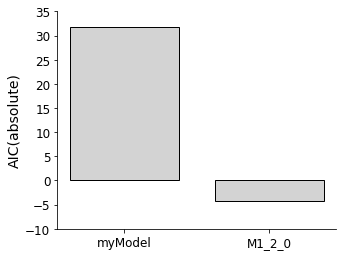

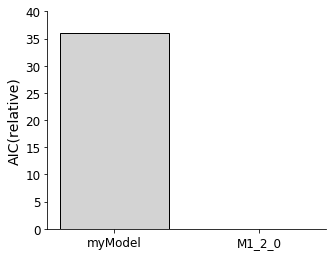

In [10]:
ax = visu.plot_selected_models(selected_models, criterion='AIC', relative=False)
ax = visu.plot_selected_models(selected_models, criterion='AIC')
ax.plot()

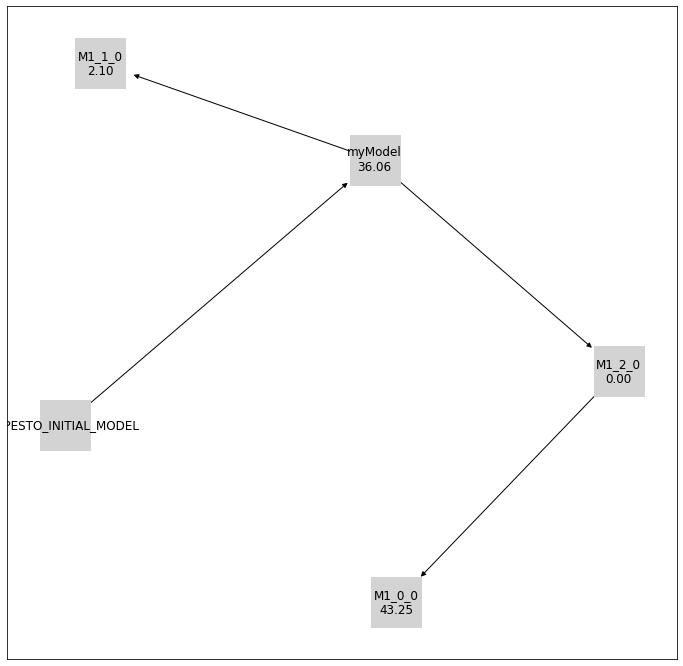

In [11]:
visu.plot_history_digraph(selection_history)

# Additional Options
There exist additional options that can be used to further customise selection algorithms.
## Select First Improvement
At each selection step, as soon as a model that improves on the previous model is encountered (by the specified criterion), it is selected and immediately used as the previous model in the next iteration of the selection. This is unlike the default behaviour, where all test models at each iteration are optimized, and the best of these is selected.
## Use Previous Maximum Likelihood Estimate as Startpoint
The maximum likelihood estimate parameters from the previous model is used as one of the startpoints in the multistart optimization of the test models. The default behaviour is that all startpoints are automatically generated by pyPESTO.
## Minimize Options
Optimization can be customised with a dictionary that specifies values for the corresponding keyword arguments of [minimize](https://github.com/ICB-DCM/pyPESTO/blob/master/pypesto/optimize/optimize.py).
## Criterion Options
Currently [`'AIC'`](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [`'BIC'`](https://en.wikipedia.org/wiki/Bayesian_information_criterion) are implemented.
### Threshold
A threshold can be specified, such that only models that improve on previous models by the threshold amount in the chosen criterion are accepted.

In [12]:
selector3 = pypesto.ModelSelector(petab_problem, model_spec_file)

minimize_options = {
    'n_starts': 10
}

while True:
    try:
        _, _, selection_history = selector3.select('forward',
                                                   'BIC',
                                                   select_first_improvement=True,
                                                   startpoint_latest_mle=True,
                                                   minimize_options=minimize_options)
    except EOFError:
        break

----------------------New Selection---------------------
Starting with model: M1_0_0

Old ID	New ID	Crit	Old	New	Diff	Result
M1_0_0	M1_1_0	BIC	36.767	-6.384	-43.151	Accepted
M1_1_0	M1_4_0	BIC	-6.384	-4.691	1.693	Rejected
M1_1_0	M1_5_0	BIC	-6.384	40.349	46.732	Rejected
----------------------New Selection---------------------
Starting with model: M1_2_0

Old ID	New ID	Crit	Old	New	Diff	Result
M1_2_0	M1_3_0	BIC	-2.899	-5.122	-2.223	Accepted
M1_3_0	M1_6_0	BIC	-5.122	-6.564	-1.443	Accepted
M1_6_0	M1_7_0	BIC	-6.564	37.488	44.052	Rejected
----------------------New Selection---------------------


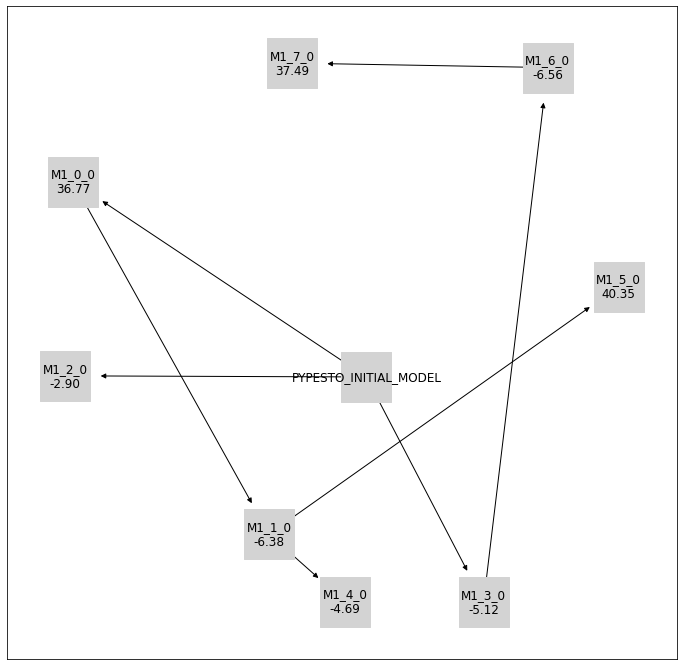

In [13]:
visu.plot_history_digraph(selection_history, criterion='BIC', relative=False)

In [14]:
# Repeat with criterion_threshold == 10
selector4 = pypesto.ModelSelector(petab_problem, model_spec_file)

minimize_options = {
    'n_starts': 10
}

while True:
    try:
        _, _, selection_history = selector4.select('forward',
                                                   'BIC',
                                                   select_first_improvement=True,
                                                   startpoint_latest_mle=True,
                                                   minimize_options=minimize_options,
                                                   criterion_threshold=10)
    except EOFError:
        break

----------------------New Selection---------------------
Starting with model: M1_0_0

Old ID	New ID	Crit	Old	New	Diff	Result
M1_0_0	M1_1_0	BIC	42.142	-6.384	-48.526	Accepted
M1_1_0	M1_4_0	BIC	-6.384	-4.691	1.693	Rejected
M1_1_0	M1_5_0	BIC	-6.384	37.262	43.646	Rejected
----------------------New Selection---------------------
Starting with model: M1_2_0

Old ID	New ID	Crit	Old	New	Diff	Result
M1_2_0	M1_3_0	BIC	25.493	-5.122	-30.615	Accepted
M1_3_0	M1_6_0	BIC	-5.122	-6.564	-1.443	Rejected
----------------------New Selection---------------------
Starting with model: M1_7_0

Old ID	New ID	Crit	Old	New	Diff	Result
----------------------New Selection---------------------


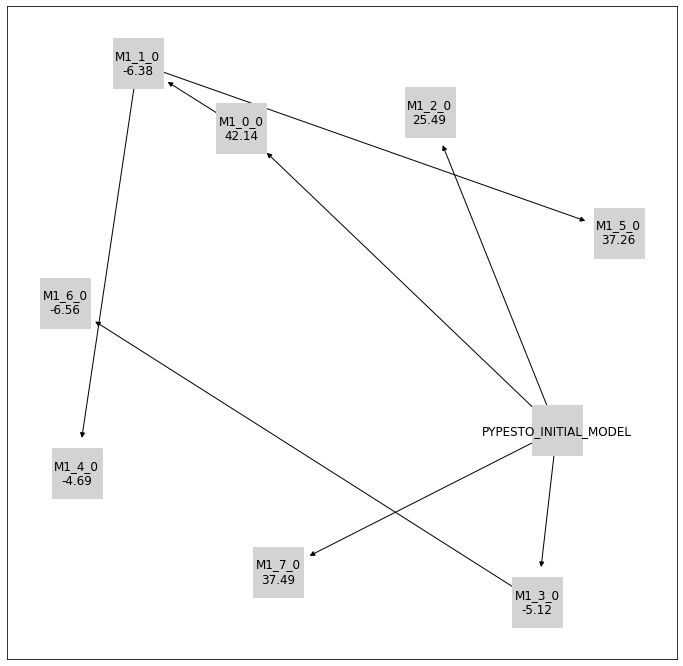

In [15]:
visu.plot_history_digraph(selection_history, criterion='BIC', relative=False)